In [1]:
import praw
import pandas as pd
import re
import string
import nltk
from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/keras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd):
    '''
    returns subreddit object with top 1000 subreddit posts
    
    '''

    with open(oa_script) as f:
    
        script = f.read().strip()

    with open(oa_secret) as f:
    
        secret = f.read().strip()

    with open(pwd) as f:
    
        pw = f.read().strip()
    
# get reddit object
    
    reddit = praw.Reddit(client_id=script,
                        client_secret=secret,
                        user_agent=app_name,
                        username='neurodivergent_ai',
                        password=pw)

    # get subreddit

    subreddit = reddit.subreddit(subreddit_name)

    # get top posts

    top = subreddit.top(limit=1000)

    for post in subreddit.top(limit=5):
    
        print(post.title, '\n')
        
    return top


def make_subreddit_df(subreddit_object):
    '''
    takes subreddit api object,
    returns as dataframe:
    
    * entire subreddit, all columns
    
    '''
    
    columns_dict = {'title': [],
                   'url': [],
                   'date': [],
                   'score': [],
                   'n_comments': [],
                   'body': []}
    
    # build dictionary
    
    for post in subreddit_object:
        
        columns_dict['title'].append(post.title)
        
        columns_dict['url'].append(post.url)
        
        columns_dict['date'].append(post.created)
        
        columns_dict['score'].append(post.score)
        
        columns_dict['n_comments'].append(post.num_comments)
        
        columns_dict['body'].append(post.selftext)
    
    # convert to dataframe
    
    subreddit_df = pd.DataFrame(columns_dict)
    
    return subreddit_df

# text cleaning: 2 different versions
# light clean for model training, heavy clean for vocab work

def light_clean(doc):
    '''
    lightly cleans input doc for
    word embedding training:
    
    * tokenizes
    * lowercase
    * removes punctuation & non-alpha characters
    
    returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # punctuation list
    
    punctuation = string.punctuation
    
    # set up regex filter
    
    rgx_punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # apply filter
    
    no_punct_tokens = [rgx_punct_filter.sub('', char) for char in split_tokens]
    
    # alpha tokens only
    
    alpha_tokens = [t for t in no_punct_tokens if t.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    return lower_tokens

def super_clean(doc):
    '''
    cleans a single input document.
    preps for vocabulary analysis.
    applies more processing than
    light_clean():
    
    * tokenizes
    * lowercase
    * removes punctuation & numbers
    * removes stopwords
    
    returns clean document.
    
    '''
    
    # tokenize
    
    split_tokens = doc.split()
    
    # grab punctuation list
    
    punctuation = string.punctuation
    
    # setup re filter
    
    rgx_punct_filter = re.compile('[%s]' % re.escape(punctuation))
    
    # apply filter
    
    no_punct_tokens = [rgx_punct_filter.sub('', char) for char in split_tokens]
    
    # take out numbers & any other non-alpha characters
    
    alpha_tokens = [i for i in no_punct_tokens if i.isalpha()]
    
    # lowercase
    
    lower_tokens = [t.lower() for t in alpha_tokens]
    
    # get stop words
    
    stop_words = set(stopwords.words('english'))
    
    # filter out stopwords
    
    go_tokens = [t for t in lower_tokens if not t in stop_words]
    
    # remove very short tokens
    
    clean_tokens = [word for word in go_tokens if len(word) > 1]
    
    return clean_tokens

def clean_all_docs(docs):
    '''
    takes a set of documents,
    applies light_clean() and 
    returns as a list
    '''
    clean_docs = []
    
    for doc in docs:
        
        doc = light_clean(doc)
        
        if doc:
            
            clean_docs.append(doc)
    
    return clean_docs


def train_w2v_model(docs):
    '''
    trains word2vec model on input set of docs.
    fits PCA projection to 2d space.
    prints 2d visualization of words in vector space.
    returns trained model.
    
    '''
    
    # train w2v model 
    
    w2v_model = Word2Vec(docs, min_count=1)
    
    # get vocab
    
    vector_vocab = w2v_model[w2v_model.wv.vocab]
    
    # fit PCA model / 2d projection
    
    pca_model = PCA(n_components=2)
    
    pca_projection = pca_model.fit_transform(vector_vocab)
    
    # plot
    
    pyplot.scatter(pca_projection[:, 0], pca_projection[:, 1])
    
    # plot with words
    
    vocab_list = list(w2v_model.wv.vocab)
    
    for i, word in enumerate(vocab_list):
        
        pyplot.annotate(word, xy=(pca_projection[i, 0], pca_projection[i, 1]))  
    
    return w2v_model

    
def get_cos_sim(model, word_1, word_2):
    
    return model.wv.similarity(word_1, word_2)


def compare_cos_sim(model, word_list, comp_word):
    '''
    retrieves cosine similarities for a word
    vs a list of words, returns list
    '''
    
    cos_sim_list = []
    
    for word in word_list:
        
        cos_sim = get_cos_sim(model, word, comp_word)
        
        in_list = []
        
        in_list.append(comp_word)
        
        in_list.append(word)
        
        in_list.append(cos_sim)
        
        cos_sim_list.append(in_list)
    
    return cos_sim_list    


def comp_cos_sim_lists(model, list_1, list_2):
    '''
    compares cosine similarities of terms
    on 2 lists. returns a list.
    '''
    
    cos_sim_list = []
    
    for word in list_1:
        
        if word not in list_2:
            
            sim_line = compare_cos_sim(model, list_2, word)
            
            cos_sim_list.append(sim_line)
    
    return cos_sim_list


def join_corpus(df):
    
    corpus = list(df['title']) + list(df['body'])
    
    return corpus


def get_top_and_bottom(df, number):
    '''
    takes integer N 
    returns 2 DataFrames:
    top & bottom N vocabulary words
    
    '''
    
    top = df[:number][:]
    
    bottom = df[-number:][:]
    
    return top, bottom


def get_vocab(docs):
    '''
    vocabulary processing
    applies super_clean() text prep
    removes stopwords
    returns vocabulary as DataFrame, 
    total training words, 
    unique vocabulary words.
    '''
    
    words = []
    
    for doc in docs:
        
        # super_clean() removes stopwords
        # returns a more useful vocabulary for analysis
        
        doc = super_clean(doc)
        
        for word in doc:
            
            words.append(word)
    
    total_words = len(words)
    
    word_counts = Counter(words)
    
    unique_words = len(word_counts)
    
    word_counts = pd.DataFrame.from_dict(word_counts, orient='index')
    
    # return df sorted by word frequency
    
    return word_counts.sort_values(by=[0], ascending=False), total_words, unique_words


def list_sims_for_mean(sim_comp_list):
    '''
    takes list of cosine similarity comparisons with words
    returns ordered list of numerical values only
    
    '''
    
    sims_for_mean = []
    
    for sub_list in sim_comp_list:
        
        for i in sub_list:
            
            # grab 3rd item/cos sim
            
            sim = i[2]
        
            sims_for_mean.append(sim)
    
    return sims_for_mean

        
def get_sim_means(sims_for_mean_1, sims_for_mean_2, sims_for_mean_3):
    '''
    takes 3 ordered lists of numerical values
    takes the mean & appends each mean to a list
    returns an ordered list of mean cosine similarities
    
    '''
    
    sim_means_list = []
    
    for i in range(len(sims_for_mean_1)):
        
        sim_mean = (sims_for_mean_1[i] + sims_for_mean_2[i] + sims_for_mean_3[i]) / 3
        
        sim_means_list.append(sim_mean)
    
    return sim_means_list
    

def get_mean_cos_sim(sim_list_1, sim_list_2, sim_list_3):
    '''
    takes 3 lists of cosine similarity comparisons with words
    gets mean cosine similarities for each term
    returns new list with terms & mean cosine sims for each term
    
    '''
    
    sims_1 = list_sims_for_mean(sim_list_1)
    
    sims_2 = list_sims_for_mean(sim_list_2)
    
    sims_3 = list_sims_for_mean(sim_list_3)
    
    means_list = get_sim_means(sims_1, sims_2, sims_3)
    
    mean_cos_sims = []
    
    # make new list with comparison terms
    
    for sub_lists in sim_list_1:
        
        for i in sub_lists:
            
            local_sim_list = []
            
            local_sim_list.append(i[0])
            
            local_sim_list.append(i[1])
            
            mean_cos_sims.append(local_sim_list)
            
    # append mean cos sim values
        
    for i in range(len(mean_cos_sims)):
        
        mean_cos_sims[i].append(means_list[i])
    
    return mean_cos_sims
                

def text_prep_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number):
    
    subreddit = get_subreddit(subreddit_name, app_name, oa_script, oa_secret, pwd)
        
    subreddit_df = make_subreddit_df(subreddit)
    
    raw_corpus = join_corpus(subreddit_df)
    
    clean_corpus = clean_all_docs(raw_corpus)
   
    # get vocab takes raw corpus, NOT clean
    vocab_df, total_words, unique_words = get_vocab(raw_corpus)
    
    top, bottom = get_top_and_bottom(vocab_df, vocab_number)
    
    return subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom, total_words, unique_words


def train_pipeline(docs, term_list_A, term_list_B):
    
    # train model
    
    trained_w2v_model = train_w2v_model(docs)
    
    term_cos_sims = comp_cos_sim_lists(trained_w2v_model, term_list_A, term_list_B)
    
    return trained_w2v_model, term_cos_sims


def final_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number, term_list_A, term_list_B):
    
    #text_prep_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number)
    # return subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom
    
    subreddit_df, raw_corpus, clean_corpus, vocab_df, top, bottom, total_words, unique_words = text_prep_pipeline(subreddit_name, app_name, oa_script, oa_secret, pwd, vocab_number)
    
    # save data to file(s)
    # prepare to export as CSVs
    # first generate unique names
    
    subreddit_df_filename = app_name + '_subreddit.csv'
    
    raw_corpus_filename = app_name + '_raw_corpus.csv'
    
    clean_corpus_filename = app_name + '_clean_corpus.csv'
    
    vocab_df_filename = app_name + '_vocab.csv'
    
    # convert lists to DataFrames
    
    raw_corpus_df = pd.DataFrame(raw_corpus)
    
    clean_corpus_df = pd.DataFrame(clean_corpus)
    
    # export to CSVs using unique filenames
    
    subreddit_df.to_csv(subreddit_df_filename)
    
    raw_corpus_df.to_csv(raw_corpus_filename)
    
    clean_corpus_df.to_csv(clean_corpus_filename)
    
    vocab_df.to_csv(vocab_df_filename)
 
    # train 3 models
    
    model_1, cos_sims_1 = train_pipeline(clean_corpus, term_list_A, term_list_B)
    
    model_2, cos_sims_2 = train_pipeline(clean_corpus, term_list_A, term_list_B)
    
    model_3, cos_sims_3 = train_pipeline(clean_corpus, term_list_A, term_list_B)
    
    final_sims_list = get_mean_cos_sim(cos_sims_1, cos_sims_2, cos_sims_3)
    
    final_sims_df = pd.DataFrame(final_sims_list)
    
    # generate unique names for the models & df
    
    model_1_filename = app_name + '_w2v_model_1.model'
    
    model_2_filename = app_name + '_w2v_model_2.model'
    
    model_3_filename = app_name + '_w2v_model_3.model'
    
    final_sims_filename = app_name + '_final_sims_list.csv'
    
    # save final cosine similarities & models to disk
    
    model_1.save(model_1_filename)
    
    model_2.save(model_2_filename)
    
    model_3.save(model_3_filename)
    
    final_sims_df.to_csv(final_sims_filename)
    
    # display results
    
    print('number of words used in training: \n')
    
    print(total_words, '\n')
    
    print('total unique vocabulary words: \n')
    
    print(unique_words, '\n')
    
    print('top vocabulary: \n')
    
    print(top, '\n')
    
    print('bottom vocabulary: \n')
    
    print(bottom, '\n')
    
    print('mean cosine similarities: \n')
    
    print(final_sims_df)
    
    return model_1, model_2, model_3, final_sims_list, total_words, unique_words


## r/The_Donald

DONALD J. TRUMP DECLARED THE WINNER! 

I’m Donald J. Trump and I'm Your Next President of the United States. 

The New Algorithm Was Designed To Keep President Trump From The Front Page... But Sadly, That Won't Happen. 

CNN will soon be #1...when searching for the term "Fake News". Congratulations to CNN on this major achievement. 

ALL CELEBRITIES THAT VOWED TO LEAVE THE U.S.A. IF TRUMP WINS, WE NOW DEMAND YOU TO FOLLOW THROUGH!!!! OUT! OUT! OUT! 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


number of words used in training: 

23412 

total unique vocabulary words: 

6478 

top vocabulary: 

              0
trump       342
us          154
president   123
clinton     121
people      118
reddit      114
like        102
would        95
hillary      90
one          80
donald       78
get          77
post         66
make         66
media        66
campaign     65
going        61
even         61
new          59
time         59
foundation   58
email        57
dont         57
news         57
first        56 

bottom vocabulary: 

                    0
prosecutors         1
cleans              1
fears               1
familiar            1
occurrence          1
taibbi              1
rolling             1
merely              1
arm                 1
nfl                 1
yates               1
comply              1
refusal             1
maxine              1
waters              1
posing              1
ukraine             1
placements          1
flynn               1
investigated       

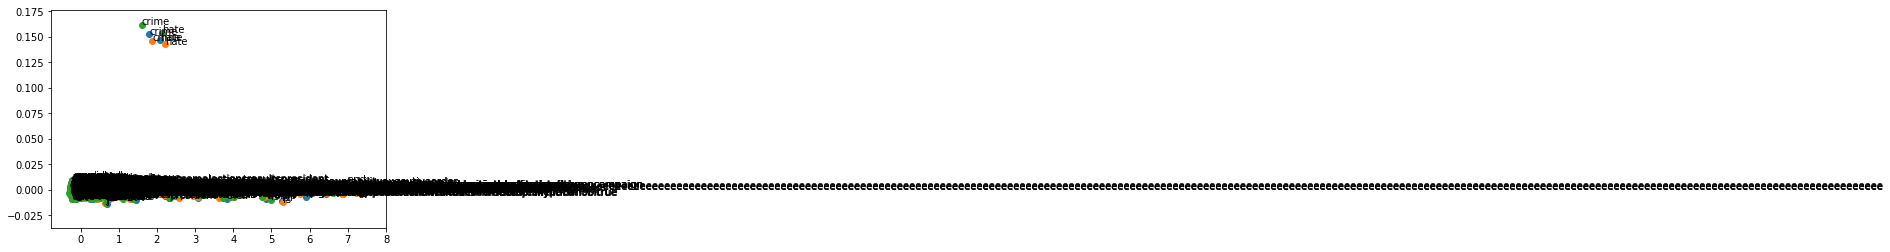

In [3]:
d_words_A = ['fox', 'flynn', 'cuck', 'pepe', 'god', 'emperor', 
             'bitch', 'alpha', 'establishment', 'soros', 'prison', 
             'email', 'corrupt', 'good', 'evil', 'smart', 'assault', 
             'honest', 'brains', 'president', 'feminist']

d_words_B = ['trump', 'clinton', 'sanders', 'liberal', 
             'conservative', 'men', 'women']

d_model_1, d_model_2, d_model_3, d_cos_sims, d_total_words, d_unique_words = final_pipeline('The_Donald', 'The_Donald', 'The_Donald_script.txt', 'The_Donald_secret.txt', 'reddit_id.txt', 25, d_words_A, d_words_B)

## r/conservative

So let me get this straight... 

Why we won 

Ben Shapiro on the 4th of July... 

Well, she's a guy, so... 

Reddit Admin u/spez Admits of Editing Users Comments 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


number of words used in training: 

7737 

total unique vocabulary words: 

3403 

top vocabulary: 

                0
trump         111
people         50
liberal        33
us             29
conservative   29
want           29
one            27
im             27
like           26
says           24
dont           24
ben            24
vs             24
black          23
left           23
kavanaugh      22
white          22
day            22
shapiro        22
president      21
new            21
bill           21
clinton        21
cnn            20
news           20 

bottom vocabulary: 

               0
room           1
fail           1
shooters       1
biological     1
childhood      1
vibes          1
props          1
taunt          1
reach          1
uncle          1
goals          1
accusers       1
sexualassault  1
swift          1
model          1
mentally       1
bombs          1
screwed        1
pauls          1
airing         1
grievances     1
festivus       1
arrivals       1


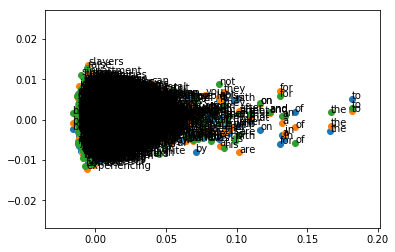

In [4]:
consrv_A = ['fox', 'manafort', 'god', 'prison', 'email', 
            'corrupt', 'good', 'evil', 'assault', 'president', 
            'feminist']

consrv_B = ['trump', 'clinton', 'sanders', 'liberal', 
            'conservative', 'men', 'women']

consrv_model_1, consrv_model_2, consrv_model_3, consrv_cos_sims, consrv_total_words, consrv_unique_words = final_pipeline('conservative', 'conservative', 'conservative_script.txt', 'conservative_secret.txt', 'reddit_id.txt', 25, consrv_A, consrv_B)

## r/KotakuInAction

[Humor] There's two kinds of people... 

Reddit bans r/whalewatching thinking its a clone of r/fatpeoplehate. It was actually a real attempt at a whale watching community and has existed for +2 years. 

[CENSORSHIP] The new age of reddit has begun. Admins ban /r/FatPeopleHate (and 4 other subreddits that the admins fail to disclose). 

Pussy Pass Denied mods are being threatened with doxxing if they don't hand over the sub over to SJWs to shut down. One mod has already lost their job. 

[Censorship]Youtube cuts ad revenue for Phillip Defranco for posting Annaliese Nielsen video 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


number of words used in training: 

34440 

total unique vocabulary words: 

8471 

top vocabulary: 

              0
people      244
like        175
one         156
dont        147
reddit      144
video       130
twitter     129
get         123
even        119
edit        118
game        104
censorship  104
would       103
new         100
media        91
im           91
women        90
also         88
post         86
time         86
games        85
gamergate    84
think        84
know         83
see          83 

bottom vocabulary: 

                                          0
rdragonquest                              1
rdiy                                      1
tekken                                    1
corporate                                 1
httpsarchiveisdpsps                       1
rgonewild                                 1
fetched                                   1
collecting                                1
monthslong                                1
uni                

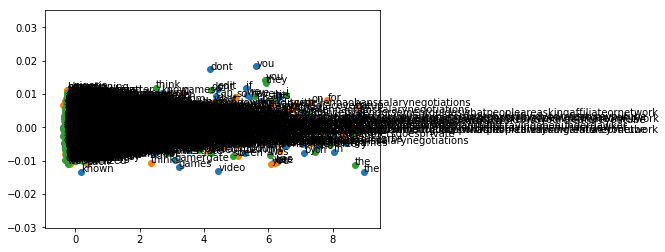

In [5]:
kotaku_A = ['fox','pepe', 'god', 'bitch', 'alpha', 'establishment', 
            'soros', 'prison', 'email', 'corrupt', 'good', 'evil', 
            'smart', 'assault', 'honest', 'brains', 'president', 'feminist']

kotaku_B = ['trump', 'clinton', 'sanders', 'liberal', 
            'conservative', 'men', 'women']

kotaku_model_1, kotaku_model_2, kotaku_model_3, kotaku_cos_sims, kotaku_total_words, kotaku_unique_words = final_pipeline('KotakuInAction', 'KotakuInAction', 'Kotaku_script.txt', 'Kotaku_secret.txt', 'reddit_id.txt', 25, kotaku_A, kotaku_B)


## r/esist

BREAKING NEWS: Supreme Court finds North Carolina GOP gerrymandering districts based on race 

Trump reveals classified information to Russian Ambassador. 

In the latest AHCA proposal, Republican lawmakers added an amendment to exempt themselves and their staff from the changes. They love Obamacare's protections. They love having pre-existing conditions covered by insurance. They just don't want you to have it too. Call them and ask them why. 

Trump says: "We have to start winning wars again." // NO - How about we not have any wars at all? This administration seems to be ramping up to get us into a war somewhere. Call your representative and tell them WE DON'T WANT ANOTHER WAR. 

Presidential sources: US President Trump calls Turkish President Erdoğan to congratulate him on Turkey referendum result. To be clear, Trump is congratulating him on a measure to effectively eliminate democracy and install a dictatorship. 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


number of words used in training: 

18134 

total unique vocabulary words: 

5577 

top vocabulary: 

               0
trump        610
us           102
people        98
president     84
white         81
tax           78
trumps        76
donald        75
would         71
house         70
million       66
russian       63
gop           62
news          61
republican    55
campaign      53
new           53
says          53
republicans   51
election      50
get           48
know          44
one           43
said          42
like          41 

bottom vocabulary: 

                                                    0
reeks                                               1
flow                                                1
count                                               1
skeptics                                            1
anywhere                                            1
scare                                               1
climatechange                                       1
t

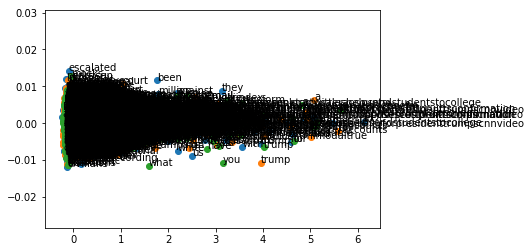

In [6]:
resist_A = ['fox', 'flynn', 'manafort','god', 'bitch', 
            'establishment', 'prison', 'email', 'corrupt', 
            'good', 'evil', 'smart', 'assault', 'president']

resist_B = ['trump', 'clinton', 'sanders', 'liberal', 
            'conservative', 'men', 'women']

resist_model_1, resist_model_2, resist_model_3, resist_cos_sims, resist_total_words, resist_unique_words = final_pipeline('esist', 'resist', 'resist_script.txt', 'resist_secret.txt', 'reddit_id.txt', 25, resist_A, resist_B)

## r/Liberal

More GOP politicians have been arrested for sexual misconduct in bathrooms than trans people 

Trump’s pledge to “start winning wars again” is ignorant and delusional — and highly dangerous. His detour into war nostalgia suggests a profound ignorance of history and no understanding of the world 

Jared Kushner 'admitted Donald Trump lies to his base because he thinks they're stupid' 

Chris Murphy: Pence walkout 'a multi million dollar political stunt paid for by taxpayers' 

Stormy Daniels to Donate $130,000 to Planned Parenthood in Trump's Name 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


number of words used in training: 

12390 

total unique vocabulary words: 

4508 

top vocabulary: 

               0
trump        304
people        67
says          61
us            55
republicans   54
president     53
new           51
donald        49
trumps        49
gop           45
republican    43
news          42
sanders       39
tax           38
obama         37
white         37
one           35
fox           35
house         34
report        34
court         33
like          33
party         32
democrats     32
americans     31 

bottom vocabulary: 

               0
spoof          1
nancy          1
airstrikes     1
weeps          1
issuing        1
visa           1
licenses       1
majorityblack  1
intense        1
wasted         1
falsifying     1
permits        1
tenants        1
request        1
ashamed        1
taibbi         1
commentator    1
widened        1
marks          1
endlessly      1
silent         1
grassley       1
waste          1
booze          1
feuernst

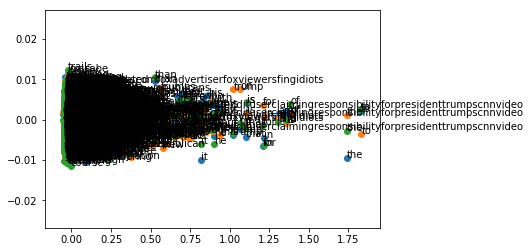

In [7]:
liberal_A = ['fox', 'flynn', 'manafort', 'god', 'prison', 
             'email', 'corrupt', 'good', 'smart', 'assault', 
             'honest', 'president']

liberal_B = ['trump', 'clinton', 'sanders', 'liberal', 
             'conservative', 'men', 'women']

lib_model_1, lib_model_2, lib_model_3, lib_cos_sims, lib_total_words, lib_unique_words = final_pipeline('Liberal', 'Liberal', 'Liberal_script.txt', 'Liberal_secret.txt', 'reddit_id.txt', 25, liberal_A, liberal_B)

## r/feminism

Some words from Maisie Williams 

This sadly happens all to often. 

This can never go away, this needs to continue to get posted over and over and over again. This should never be forgotten 

About abortion 

Got this on my feed today. 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:210: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


number of words used in training: 

15372 

total unique vocabulary words: 

5050 

top vocabulary: 

            0
women     296
men       141
woman     113
rape       86
feminist   82
like       81
sexual     81
people     74
feminism   70
female     69
first      59
im         56
one        54
get        54
time       54
male       53
man        53
dont       51
would      49
us         49
sex        47
know       45
never      45
girls      45
girl       43 

bottom vocabulary: 

               0
finance        1
suffragettes   1
toy            1
helpful        1
germany        1
turkey         1
simulates      1
heisting       1
tablets        1
typical        1
antifeminists  1
friendzone     1
satanic        1
temple         1
immunity       1
rule           1
burials        1
happiness      1
assignment     1
riddle         1
cyanide        1
antirape       1
protestor      1
koln           1
feet           1 

mean cosine similarities: 

            0             1         2
0

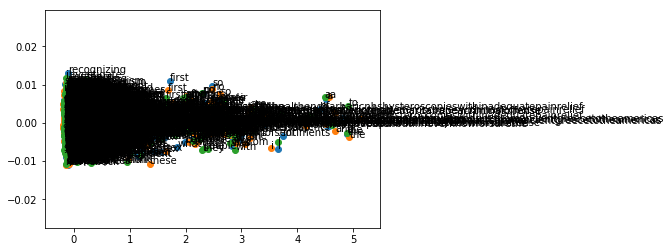

In [8]:
fem_A = ['fox', 'god', 'bitch', 'prison', 'good', 
         'evil', 'smart', 'assault', 'honest', 
         'brains', 'president', 'feminist']

fem_B = ['trump', 'clinton', 'sanders', 'liberal', 
         'conservative', 'men', 'women']

fem_model_1, fem_model_2, fem_model_3, fem_cos_sims, fem_total_words, fem_unique_words = final_pipeline('feminism', 'feminism', 'feminism_script.txt', 'feminism_secret.txt', 'reddit_id.txt', 25, fem_A, fem_B)

## vocabulary stats

In [9]:
mean_training_vocab = (d_total_words + consrv_total_words + kotaku_total_words + resist_total_words + fem_total_words + lib_total_words) / 6

mean_unique_words = (d_unique_words + consrv_unique_words + kotaku_unique_words + resist_unique_words + fem_unique_words + lib_unique_words) / 6

In [10]:
print('mean training vocabulary size: \n')

print(mean_training_vocab, '\n')

print('mean unique vocabulary words: \n')

print(mean_unique_words)

mean training vocabulary size: 

18580.833333333332 

mean unique vocabulary words: 

5581.166666666667
